In [16]:
# !pip install PyPortfolioOpt

In [17]:
# 필요한 라이브러리들을 불러옵니다.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 포트폴리오 최적화를 위한 PyPortfolioOpt 라이브러리
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- 설정값 ---
INPUT_FILENAME = "top_50_zscore_rank_3Y.csv"
# ---

try:
    top_50_df = pd.read_csv(INPUT_FILENAME)
    tickers = top_50_df['Ticker'].tolist()
    tickers = list(set(tickers))

    print(f"✅ '{INPUT_FILENAME}'에서 상위 {len(tickers)}개 티커를 불러왔습니다.")
    print(tickers)
except FileNotFoundError:
    print(f"❌ 오류: '{INPUT_FILENAME}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
    tickers = []



✅ 'top_50_zscore_rank_3Y.csv'에서 상위 50개 티커를 불러왔습니다.
['RKLB', 'CIFR', 'HCA', 'APP', 'APLD', 'IESC', 'VRNA', 'POWL', 'QUBT', 'HOOD', 'WULF', 'SKYX', 'CVNA', 'HIMS', 'CLS', 'UAMY', 'ACIC', 'RGTI', 'IONQ', 'PLTR', 'LMB', 'STRL', 'TPC', 'SMMT', 'STKE', 'INOD', 'MOD', 'IAG', 'PSIX', 'ROOT', 'AMSC', 'MFH', 'VRT', 'OKLO', 'DAVE', 'TSSI', 'VKTX', 'RYTM', 'SLNO', 'FTAI', 'PPTA', 'MAMA', 'AAOI', 'ASM', 'IREN', 'HRTG', 'QURE', 'ABBV', 'MSTR', 'CRDO']


In [18]:
# if tickers:
#     # 데이터 수집 기간 설정 (오늘부터 3년 전까지)
#     end_date = datetime.today()
#     start_date = end_date - timedelta(days=3*365)
    
#     print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
#     # yfinance를 통해 50개 종목의 수정 종가 데이터를 다운로드합니다.
#     prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna(how="all")
#     print("\n✅ 주가 데이터 수집 완료!")
#     display(prices.head())

In [19]:
if tickers:
    # 데이터 수집 기간 설정
    end_date = datetime.today()
    start_date = end_date - timedelta(days=3*365)
    
    print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
    # yfinance를 통해 전체 데이터를 다운로드합니다.
    # 최신 버전에서는 auto_adjust=True가 기본값이므로 'Adj Close'가 아닌 'Close'를 사용합니다.
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # 'Close' 컬럼만 선택합니다. (이것이 이제 수정 종가입니다)
    if isinstance(data.columns, pd.MultiIndex):
        prices = data['Close'] # 이 부분을 수정
    else:
        prices = data[['Close']] # 이 부분도 수정

    prices = prices.dropna(how="all")
    
    print("\n✅ 주가 데이터 수집 완료!")
    display(prices.head())




✅ 데이터 수집 기간: 2022-10-05 ~ 2025-10-04


C:\Users\k-271\AppData\Local\Temp\ipykernel_21688\3381222765.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  50 of 50 completed


✅ 주가 데이터 수집 완료!


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASM,CIFR,CLS,CRDO,CVNA,DAVE,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MAMA,MFH,MOD,MSTR,OKLO,PLTR,POWL,PPTA,PSIX,QUBT,QURE,RGTI,RKLB,ROOT,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TPC,TSSI,UAMY,VKTX,VRNA,VRT,WULF
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-05,3.01,128.038956,0.587340,4.77,1.65,20.760000,0.60,1.31,9.11,11.61,21.549999,14.112,15.727021,197.501572,5.70,10.76,2.33,1.16,29.090000,3.40,5.71,4.49,8.02,1.09,0.938889,14.05,24.219000,9.73,8.42,21.045553,2.17,1.6,2.42,20.110001,1.96,4.61,9.09,26.010000,3.30,1.72,1.06,0.480,23.230000,6.17,0.55,0.38,2.90,10.60,11.947321,1.54
2022-10-06,2.93,125.323250,0.606597,4.53,1.62,20.540001,0.60,1.27,9.07,11.57,21.129999,14.144,15.689972,196.516708,5.65,11.17,2.20,1.14,28.790001,3.31,5.64,4.40,8.05,1.09,0.956667,13.66,24.167000,9.73,8.47,20.419195,2.14,1.7,2.40,20.209999,1.96,4.62,8.64,25.840000,3.43,1.73,1.09,0.208,23.379999,5.92,0.61,0.38,2.95,10.41,11.817783,1.78
2022-10-07,2.78,123.956482,0.596969,4.31,1.55,19.219999,0.57,1.14,8.99,10.99,19.270000,12.512,14.745241,195.473343,5.38,10.80,2.01,1.11,28.379999,3.41,5.28,3.71,7.69,1.09,0.911111,13.23,22.030001,9.75,8.15,20.293924,1.94,1.5,2.31,19.290001,1.89,4.36,8.20,23.950001,3.32,1.56,1.02,0.360,22.450001,5.75,0.61,0.36,2.87,10.13,10.911024,1.36
2022-10-10,2.67,123.554489,0.596969,3.98,1.60,18.480000,0.54,1.12,8.73,10.34,18.209999,12.064,14.198777,194.137421,4.99,10.52,1.82,1.07,29.260000,3.28,5.07,3.57,7.75,1.10,0.975556,13.39,22.065001,9.75,8.06,20.245747,1.81,1.5,2.05,18.600000,1.94,4.30,8.38,23.240000,3.28,1.50,1.13,0.320,22.809999,5.95,0.61,0.36,2.83,9.98,11.199991,1.30
2022-10-11,2.63,126.413094,0.548826,3.88,1.68,17.770000,0.54,1.04,8.55,9.88,18.320000,11.840,14.143205,197.647888,5.05,10.44,1.62,1.08,28.570000,3.27,4.89,3.41,7.62,1.09,1.177778,13.58,21.636999,9.74,8.04,20.274651,1.88,1.5,2.07,18.830000,1.90,4.19,8.52,23.549999,3.37,1.39,1.09,0.320,22.660000,5.88,0.61,0.36,2.94,9.97,11.040563,1.13


In [20]:
if not prices.empty:
    # 1. 연간 기대수익률 계산 (과거 데이터 기반)
    mu = expected_returns.mean_historical_return(prices)
    # mu = expected_returns.ema_historical_return(prices)
    
    # 2. 연간 공분산 행렬 계산 (위험 모델)
    S = risk_models.sample_cov(prices)
    
    print("✅ 연간 기대수익률 (mu):")
    display(mu.head())
    print("\n✅ 연간 공분산 행렬 (S):")
    display(S.head())

✅ 연간 기대수익률 (mu):


Ticker
AAOI    1.111780
ABBV    0.224098
ACIC    1.725732
AMSC    1.329563
APLD    1.539577
dtype: float64


✅ 연간 공분산 행렬 (S):


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASM,CIFR,CLS,CRDO,CVNA,DAVE,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MAMA,MFH,MOD,MSTR,OKLO,PLTR,POWL,PPTA,PSIX,QUBT,QURE,RGTI,RKLB,ROOT,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TPC,TSSI,UAMY,VKTX,VRNA,VRT,WULF
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAOI,1.504019,0.004930,0.054033,0.377327,0.354679,0.318581,0.095497,0.430719,0.254566,0.324495,0.347553,0.254459,0.157284,0.019586,0.217595,0.262264,0.071032,0.092393,0.233330,0.430723,0.380243,0.385909,0.163233,0.048807,0.041146,0.232070,0.268888,0.189092,0.256923,0.161328,0.067616,0.178257,0.383588,0.112336,0.418554,0.224335,0.099519,0.130229,0.172887,0.107059,0.084236,0.295848,0.168391,0.126262,0.240410,0.155934,0.198939,0.115503,0.279806,0.412886
ABBV,0.004930,0.053323,0.000325,0.004390,-0.008559,0.005776,0.018080,0.007663,0.001486,-0.001839,-0.010168,0.008341,0.009924,0.011448,0.006577,0.006796,0.010033,0.009086,0.002777,-0.005276,0.003161,-0.014745,0.001730,0.004509,-0.024947,0.000171,-0.012382,0.000841,0.008657,0.000611,0.004971,-0.000736,0.014343,0.008060,0.003890,0.004331,0.010515,0.020407,0.008328,0.004768,0.027216,-0.014207,-0.002155,-0.000065,0.017693,0.010680,0.033171,0.012761,-0.000818,0.003880
ACIC,0.054033,0.000325,1.122977,0.097444,0.186943,0.036344,-0.002482,0.116858,0.028694,-0.011125,0.063958,0.070459,0.025839,0.019164,0.013454,0.042144,0.186790,0.043146,0.056314,0.093336,0.089266,0.061341,0.054335,0.096936,0.022962,0.011622,0.050321,-0.032557,0.055656,0.053022,0.056191,0.075544,0.044407,0.053516,0.061895,0.051084,0.028284,0.066735,0.086860,-0.083008,0.002126,-0.057404,0.038280,0.016117,0.061392,0.017625,0.067719,0.060355,0.009551,-0.004488
AMSC,0.377327,0.004390,0.097444,0.857890,0.306298,0.185994,0.070453,0.269856,0.150555,0.199986,0.324313,0.188645,0.115192,0.023389,0.185528,0.183925,0.093896,0.079138,0.177301,0.332639,0.279244,0.294056,0.157882,0.050117,0.089406,0.174741,0.240037,0.163552,0.185849,0.103393,0.104817,0.093109,0.206862,0.098138,0.348151,0.222488,0.176795,0.181418,0.164766,0.030090,0.185792,0.101200,0.152642,0.165476,0.186687,0.096010,0.108065,0.111862,0.154093,0.281584
APLD,0.354679,-0.008559,0.186943,0.306298,1.674390,0.206788,0.127317,0.559576,0.161340,0.211138,0.318003,0.177789,0.097273,0.008650,0.174227,0.250618,0.054932,0.102252,0.149939,0.292299,0.385669,0.490362,0.162320,0.087129,0.164632,0.193529,0.319455,0.238873,0.219695,0.159558,0.183081,0.128652,0.297276,-0.008323,0.389007,0.233373,0.164358,0.102279,0.127058,0.115500,0.040196,-0.015867,0.157156,0.150972,0.323535,0.179961,0.151354,0.087263,0.193622,0.608557


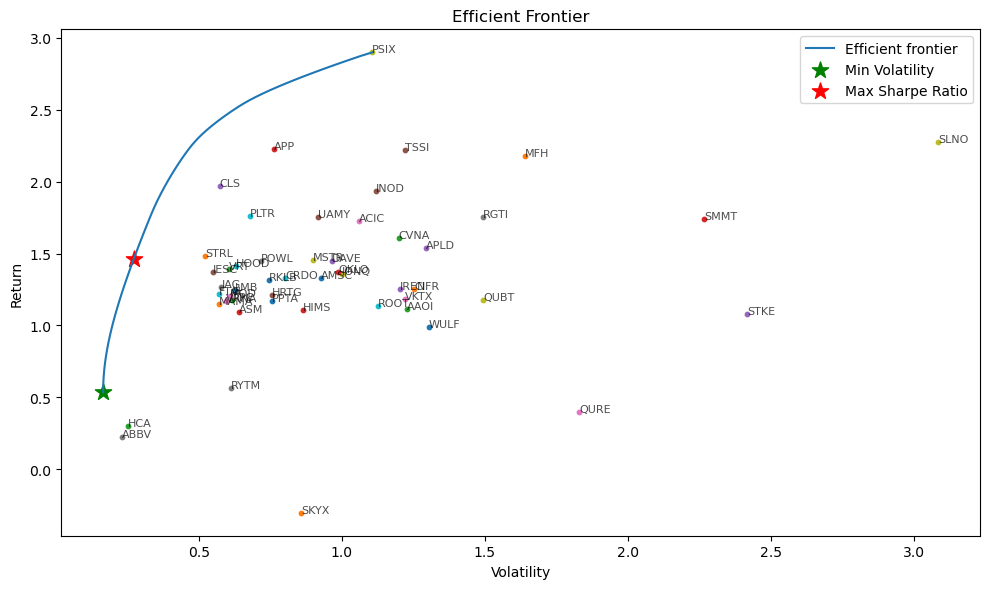


--- 최소 변동성 포트폴리오 ---
기대수익률: 53.52%, 변동성(리스크): 16.57%

--- 최대 샤프 지수 포트폴리오 ---
기대수익률: 146.39%, 변동성(리스크): 27.31%


In [21]:

# 'mu'와 'S'는 이미 계산되었다고 가정합니다.
if 'mu' in locals() and 'S' in locals():
    
    # 1. 최소 변동성 포트폴리오 계산
    # 객체를 새로 생성합니다.
    ef_min_vol = EfficientFrontier(mu, S)
    min_vol_weights = ef_min_vol.min_volatility()
    min_vol_ret, min_vol_risk, _ = ef_min_vol.portfolio_performance()
    
    # 2. 최대 샤프 지수 포트폴리오 계산
    # 객체를 다시 새로 생성합니다.
    ef_max_sharpe = EfficientFrontier(mu, S)
    max_sharpe_weights = ef_max_sharpe.max_sharpe()
    max_sharpe_ret, max_sharpe_risk, _ = ef_max_sharpe.portfolio_performance()

    # 3. 시각화 (효율적 투자선은 한 번만 계산)
    ef_for_plotting = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(10, 6))
    plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=False)
    
    # 계산된 포트폴리오 결과 플로팅
    ax.scatter(min_vol_risk, min_vol_ret, marker="*", color="g", s=150, label="Min Volatility")
    ax.scatter(max_sharpe_risk, max_sharpe_ret, marker="*", color="r", s=150, label="Max Sharpe Ratio")

    # # 각 포트폴리오의 티커별 위치 표시
    for ticker in tickers:
        ret = mu[ticker]
        risk = np.sqrt(S.loc[ticker, ticker])
        ax.scatter(risk, ret, marker="o", s=10)
        ax.text(risk, ret, ticker, fontsize=8, alpha=0.7)
    

    # 그래프 스타일 설정
    ax.set_title("Efficient Frontier")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n--- 최소 변동성 포트폴리오 ---")
    print(f"기대수익률: {min_vol_ret:.2%}, 변동성(리스크): {min_vol_risk:.2%}")
    
    print("\n--- 최대 샤프 지수 포트폴리오 ---")
    print(f"기대수익률: {max_sharpe_ret:.2%}, 변동성(리스크): {max_sharpe_risk:.2%}")

In [22]:
def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)
            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [23]:
import json # JSON 라이브러리 추가

def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)

            # 📌 추가된 부분: p가 0.65일 때 JSON 파일로 저장
            if p == 0.65:
                # 가중치가 0.1% 이상인 종목만 필터링하여 새로운 딕셔너리 생성
                weights_to_save = {ticker: weight for ticker, weight in target_weights.items() if weight > 0.001}
                
                output_json_filename = 'portfolio_weights_65_risk.json'
                with open(output_json_filename, 'w', encoding='utf-8') as f:
                    json.dump(weights_to_save, f, ensure_ascii=False, indent=4)
                
                print(f"\n  ✨ 65% 리스크 포트폴리오가 '{output_json_filename}' 파일로 저장되었습니다.")

            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [24]:

# 맥스 샤프 비율 포트폴리오 가중치를 JSON 파일로 저장
if 'max_sharpe_weights' in locals():
    # 가중치가 0.1% 이상인 종목만 필터링
    filtered_weights = {ticker: weight for ticker, weight in max_sharpe_weights.items() if weight > 0.001}
    
    # JSON 파일로 저장
    output_json_filename = 'portfolio_weights_max_sharpe.json'
    with open(output_json_filename, 'w', encoding='utf-8') as f:
        json.dump(filtered_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 맥스 샤프 비율 포트폴리오 가중치가 '{output_json_filename}' 파일로 저장되었습니다.")
    print(f"   - 종목 수: {len(filtered_weights)}")
    print(f"   - 가중치 합계: {sum(filtered_weights.values()):.4f}")


✅ 맥스 샤프 비율 포트폴리오 가중치가 'portfolio_weights_max_sharpe.json' 파일로 저장되었습니다.
   - 종목 수: 20
   - 가중치 합계: 1.0000


In [29]:
input_filename = 'portfolio_weights_max_sharpe.json'
try:
    with open(input_filename, 'r', encoding='utf-8') as f:
        weights = json.load(f)
    
    # 현재 가중치 합계 계산
    current_sum = sum(weights.values())
    
    # 기존 가중치를 조정하여 총합이 0.6이 되도록 스케일링
    M_V = 0.4

    # 모든 가중치를 소수점 자리까지 반올림
    scaling_factor = 1-M_V / current_sum
    scaled_weights = {ticker: weight * scaling_factor for ticker, weight in weights.items()}
    rounded_weights = {ticker: round(weight, 3) for ticker, weight in scaled_weights.items()}

    # MONEY 티커 추가 (비중 0.4)
    scaled_weights['MONEY'] = M_V

    # 라운딩으로 인한 오차를 보정하여 정확히 합계가 1이 되도록 조정
    total_after_rounding = sum(rounded_weights.values())
    if total_after_rounding != 1.00:
        # 가장 큰 가중치를 가진 티커에 오차를 더하거나 빼서 합계를 1로 맞춤
        max_ticker = max(rounded_weights.items(), key=lambda x: x[1] if x[0] != 'MONEY' else 0)[0]
        rounded_weights[max_ticker] = round(rounded_weights[max_ticker] + (1.00 - total_after_rounding), 3)
    
    # 최종 포트폴리오 가중치를 JSON 파일로 저장
    output_filename = 'final_portfolio_weights.json'
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(rounded_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 최종 포트폴리오 가중치가 '{output_filename}' 파일로 저장되었습니다.")
    print(f"   - MONEY 비중: {rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 기타 자산 비중 총합: {sum(rounded_weights.values()) - rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 전체 비중 총합: {sum(rounded_weights.values()):.3f}")
    
except FileNotFoundError:
    print(f"❌ 오류: '{input_filename}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
except Exception as e:
    print(f"❌ 오류 발생: {str(e)}")


✅ 최종 포트폴리오 가중치가 'final_portfolio_weights.json' 파일로 저장되었습니다.
   - MONEY 비중: 0.000
   - 기타 자산 비중 총합: 1.000
   - 전체 비중 총합: 1.000


In [30]:
import json

# --- 설정 ---
# 1. 최대 샤프 지수 가중치가 저장된 JSON 파일 경로
max_sharpe_weights_path = r'final_portfolio_weights.json'
# 2. 최종 포트폴리오를 저장할 파일 경로 (선택 사항)
final_portfolio_path = r'final_portfolio_with_cash.json'

# 3. 고정할 현금(MONEY) 비중
CASH_WEIGHT = 0.4
# 4. 나머지 자산에 할당될 비중
EQUITY_WEIGHT = 1 - CASH_WEIGHT

# --- 로직 ---
# 기존 포트폴리오 가중치 로드
with open(max_sharpe_weights_path, 'r', encoding='utf-8') as f:
    original_weights = json.load(f)

# 새로운 가중치를 계산할 딕셔너리 생성
adjusted_weights = {}

# 각 자산의 가중치를 남은 비중(0.6)에 맞춰 재계산하고 소수점 3자리에서 반올림
for ticker, weight in original_weights.items():
    adjusted_weights[ticker] = round(weight * EQUITY_WEIGHT, 3)

# 반올림 후 MONEY를 제외한 나머지의 합계 계산
equity_sum = sum(adjusted_weights.values())

# MONEY를 제외한 나머지의 합이 정확히 0.6이 되도록 조정
if equity_sum != EQUITY_WEIGHT:
    # 가장 큰 가중치를 가진 자산에 오차를 보정
    difference = round(EQUITY_WEIGHT - equity_sum, 3)
    max_ticker = max(adjusted_weights.items(), key=lambda x: x[1])[0]
    adjusted_weights[max_ticker] = round(adjusted_weights[max_ticker] + difference, 3)

# 현금 비중 추가
adjusted_weights['MONEY'] = CASH_WEIGHT

# --- 결과 확인 ---
print("✅ 현금 비중 0.4를 적용하여 포트폴리오 가중치를 재조정했습니다.")
print("\n--- 최종 조정된 포트폴리오 가중치 ---")

# 보기 좋게 정렬하여 출력
for ticker, weight in sorted(adjusted_weights.items()):
    print(f"- {ticker:<6}: {weight:.3f}")

print("---------------------------------------")
# MONEY를 제외한 자산들의 합계와 전체 합계 검증
equity_total = sum(v for k, v in adjusted_weights.items() if k != 'MONEY')
total_weight = sum(adjusted_weights.values())
print(f"📊 MONEY 제외 총 가중치: {equity_total:.3f}")
print(f"📊 전체 가중치 합계: {total_weight:.3f}")


# --- 파일 저장 (필요시 주석 해제) ---
with open(final_portfolio_path, 'w', encoding='utf-8') as f:
    json.dump(adjusted_weights, f, indent=4)
print(f"\n✅ 조정된 포트폴리오를 '{final_portfolio_path}' 파일에 저장했습니다.")


✅ 현금 비중 0.4를 적용하여 포트폴리오 가중치를 재조정했습니다.

--- 최종 조정된 포트폴리오 가중치 ---
- ABBV  : 0.287
- ACIC  : 0.014
- APP   : 0.028
- ASM   : 0.001
- CLS   : 0.043
- FTAI  : 0.013
- HCA   : 0.017
- HRTG  : 0.014
- IAG   : 0.033
- MAMA  : 0.035
- MFH   : 0.013
- MONEY : 0.400
- PLTR  : 0.007
- POWL  : 0.011
- PSIX  : 0.028
- SLNO  : 0.004
- SMMT  : 0.003
- STRL  : 0.013
- TSSI  : 0.010
- UAMY  : 0.009
- VRNA  : 0.017
---------------------------------------
📊 MONEY 제외 총 가중치: 0.600
📊 전체 가중치 합계: 1.000

✅ 조정된 포트폴리오를 'final_portfolio_with_cash.json' 파일에 저장했습니다.
